In [91]:
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.manifold import TSNE
import seaborn as sns
from PIL import Image

In [81]:
path = r"/home/vlad/universitet/ProjektDA/Image-clustering-project/Image_Data/ZAsaa1YOBks/"
# change the working directory to the path where the images are located
os.chdir(path)
tsne_df = pd.DataFrame()
# this list holds all the image filename
image_paths = []
data_dir = "/Image_Data/ZAsaa1YOBks/"
# creates a ScandirIterator aliased as files
for index, directories in enumerate(os.walk(path)):
    for sample in directories[2]:
        if sample.endswith('.png'):
            image_paths.append(path + sample)
tsne_df["Image Name"] = image_paths
print(tsne_df)

                                            Image Name
0    /home/vlad/universitet/ProjektDA/Image-cluster...
1    /home/vlad/universitet/ProjektDA/Image-cluster...
2    /home/vlad/universitet/ProjektDA/Image-cluster...
3    /home/vlad/universitet/ProjektDA/Image-cluster...
4    /home/vlad/universitet/ProjektDA/Image-cluster...
..                                                 ...
197  /home/vlad/universitet/ProjektDA/Image-cluster...
198  /home/vlad/universitet/ProjektDA/Image-cluster...
199  /home/vlad/universitet/ProjektDA/Image-cluster...
200  /home/vlad/universitet/ProjektDA/Image-cluster...
201  /home/vlad/universitet/ProjektDA/Image-cluster...

[202 rows x 1 columns]


In [41]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224, 224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1, 224, 224, 3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
def combine_images(columns, space, images):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
    return background

In [57]:
def perform_KMeans(data, min_clusters, max_clusters):
    # --------- CALCULATE K-MEANS CLUSTERS ------------
    sse = []
    silhouette_coefficients = []
    labels = []
    for nr_clusters in range(min_clusters, max_clusters+1):
        kmeans = KMeans(init = "random", n_clusters = nr_clusters, n_init = 10, max_iter=300, random_state = 22)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_coefficients.append(score)
        labels.append(kmeans.labels_)
    return sse, score, silhouette_coefficients, labels

In [ ]:
# load model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [46]:
data = {}
p = r"/home/vlad/universitet/ProjektDA/Image-clustering-project/features/flower_features.pkl"

# lop through each image in the dataset
for flower in image_paths:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower, model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p, 'wb') as file:
            pickle.dump(data, file)


# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)
feat.shape
(210, 4096)



1/1 [==============================] - 0s 284ms/step


(210, 4096)

In [52]:
print(feat)

[[0.         0.5909953  1.1337146  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.44416353 0.         0.        ]
 [0.         0.838642   0.         ... 0.23798046 0.         2.5965295 ]
 ...
 [1.4522324  0.         0.         ... 0.         0.         0.89516115]
 [0.         0.         0.36865452 ... 0.4514351  0.         0.        ]
 [0.7258918  0.         0.         ... 0.         0.         2.481297  ]]


In [53]:
# Standardize z
scaler = StandardScaler()
scaler.fit(feat)
feat = scaler.transform(feat)
print(feat)

[[-0.33709022  0.508146    0.569208   ... -0.5683452  -0.5880838
  -0.5276706 ]
 [-0.33709022 -0.43858364 -0.48764735 ... -0.01201404 -0.5880838
  -0.5276706 ]
 [-0.33709022  0.90485716 -0.48764735 ... -0.2702659  -0.5880838
   2.0185947 ]
 ...
 [ 2.1590397  -0.43858364 -0.48764735 ... -0.5683452  -0.5880838
   0.35016185]
 [-0.33709022 -0.43858364 -0.14398547 ... -0.00290614 -0.5880838
  -0.5276706 ]
 [ 0.91058916 -0.43858364 -0.48764735 ... -0.5683452  -0.5880838
   1.9055929 ]]


In [54]:
pca = PCA(0.95, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print(x.shape)
print(x)


(202, 135)
[[-15.19459     -1.2965397   -7.3013306  ...  -0.12145817  -4.451663
   -1.9141393 ]
 [-11.912085    -9.539061    -7.208286   ...   3.2372754    5.88469
   -1.664389  ]
 [  9.383682    31.053522   -11.57286    ...  -1.2817128    1.9661008
    5.629104  ]
 ...
 [ 25.311045     4.818861    -3.9584239  ...   0.6636342    0.529751
   -0.15682739]
 [ -0.06531703 -10.382985     2.248289   ...  -0.08514495  -1.6230881
   -0.03792426]
 [ 26.599028     9.4117365   -5.3938146  ...   0.14646342  -5.1211624
    2.2524421 ]]


In [64]:
# Kmeans K

min_cluster = 2
max_cluster = 10
sse, score, silhouette_coefficients, labels = perform_KMeans(x, min_cluster, max_cluster)

In [70]:
kl = KneeLocator(range(min_cluster, max_cluster+1), sse, curve="convex", direction="decreasing")
print(kl.elbow)
n_clusters = np.argmax(silhouette_coefficients)+min_cluster
print(f"Silhouette coefficient: {n_clusters} clusters return best results")

None
Silhouette coefficient: 2 clusters return best results


/home/vlad/.local/lib/python3.9/site-packages/kneed/knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [82]:
# Create Visual Evaluation
X = TSNE(n_components=2, perplexity=4).fit_transform(x)
cluster_labels = pd.Series(labels[np.argmax(silhouette_coefficients)])
tsne_df['ClusterID'] = cluster_labels.values
tsne_df["X_tsne"]  = X[:, 0]
tsne_df["Y_tsne"] = X[:, 1]

/home/vlad/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vlad/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


                                          Image Name  ClusterID     X_tsne  \
0  /home/vlad/universitet/ProjektDA/Image-cluster...          0  21.511002   
1  /home/vlad/universitet/ProjektDA/Image-cluster...          0  24.809299   
2  /home/vlad/universitet/ProjektDA/Image-cluster...          1 -36.795639   
3  /home/vlad/universitet/ProjektDA/Image-cluster...          1  53.056442   
4  /home/vlad/universitet/ProjektDA/Image-cluster...          0  -6.417378   

      Y_tsne  
0  16.127745  
1  21.391184  
2  -6.987594  
3  27.326344  
4  26.034760  


/tmp/ipykernel_15503/396374838.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


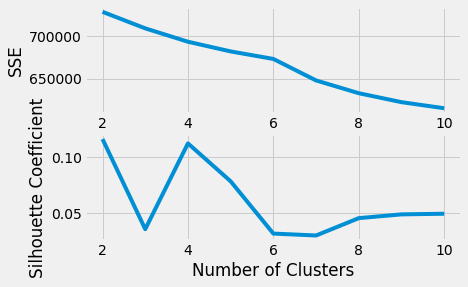

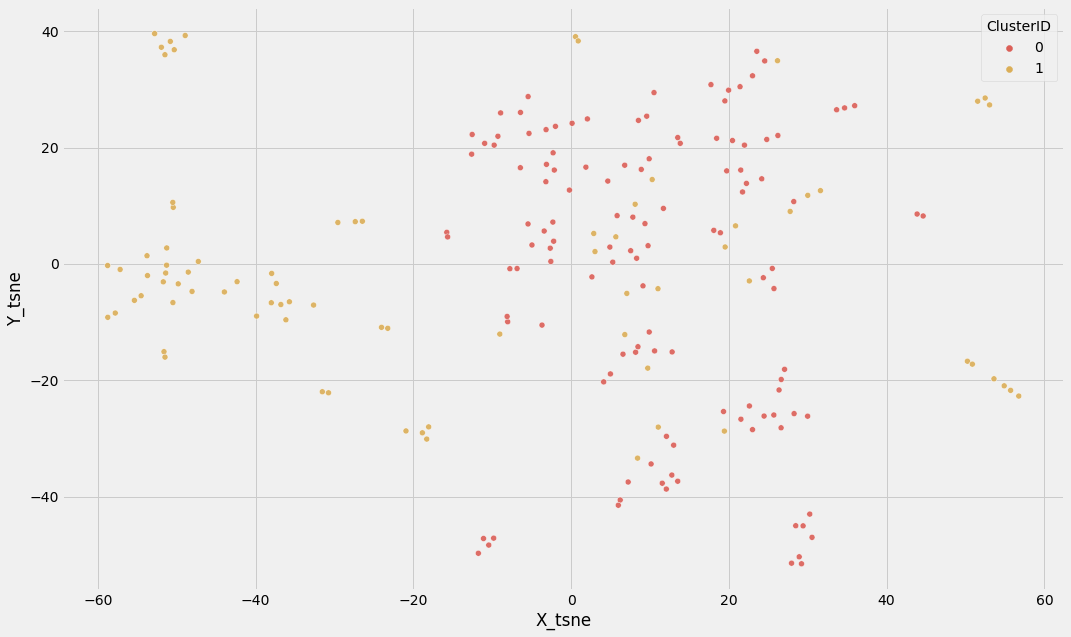

In [88]:
#Plotting Elbow Method & Silhouette 

fig, axes = plt.subplots(2, 1)
plt.style.use("fivethirtyeight")
axes[0].plot(range(min_cluster, max_cluster+1), sse)
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("SSE")
axes[1].plot(range(min_cluster, max_cluster+1), silhouette_coefficients)
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhouette Coefficient")

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="X_tsne", y="Y_tsne",
    hue="ClusterID",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.9
)
plt.show()

In [98]:
for cluster_number in range(n_clusters):
    cluster = tsne_df.loc[tsne_df["ClusterID"]==cluster_number]
    image_list = []
    for image_path in cluster["Image Name"]:
        #print(image_path)
        image_list.append(image_path)

    column_number = int(np.ceil(np.sqrt(len(image_list))))

    merged_image = combine_images(columns=column_number, space=10, images=image_list)
    
    results_path=os.getcwd()
    merged_image.save()
    print(merged_image)from PIL import Image
    merged_image.show()

<PIL.Image.Image image mode=RGBA size=7790x3972 at 0x7F16241A8C70>
<PIL.Image.Image image mode=RGBA size=5840x3248 at 0x7F16041F9700>


In [104]:
#results_path = r"/home/vlad/universitet/ProjektDA/Image-clustering-project"

#os.mkdir("Results")

In [103]:
#print(os.getcwd())


/home/vlad/universitet/ProjektDA/Image-clustering-project
